## Part 2: Valuation of certificates ##
Choose a traded product based on your underlying in Part 1 for which at least one year daily data of historic prices is available and which cannot be evaluated with closed-form Black- Scholes pricing functions.


### 2.1 Volatility of the underlying ###
Estimate the 100-trading day backward-looking volatility of the return of your underlying for each day within a reasonably chosen time window. Implement a pricing approach for your product. Determine the forward-looking volatility of the underlying implied in the ob- served market price of your product for each day of your chosen time window. Comment on potential deviations between the forward- and backward-looking volatilities.

#### 2.1 Results ####
The underlying is the S&P500. The product is UBS’ Knock-Out warrant
(turbo call warrant) expiring on August 14th, 2024. Using a rolling 100-
day volatility window from the S&P500 from 2022-07-01 to 2024-07-01,
the mean 100-day volatility is 14.80%. Using a Monte-carlo approach
and a binomial pricing model to price the product, the calculated price is
within a ~3.8-4.1 EUR range. The closing price on July 17th was 1.59
EUR. The forward looking volatility on this 30-day window (since expiry
is August) through the binomial model, is ~11.62%. The deviations
between the backward and forward volatilities occur in (1) rolling
window and (2) basis risk. The product only uses a 30 day time frame,
so the data is moderately insufficient, and furthermore, the product may
inconsistently track the underlying depending on supply and demand for
it, thereby understanding or overstating forward-looking implied
volatilities.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

# Fetching historical data for S&P 500 from Yahoo Finance, dont add the csv file
ticker = '^GSPC'
data = yf.download(ticker, start='2022-07-01', end='2024-07-01')
data['log_returns'] = np.log(data['Close'] / data['Close'].shift(1))
data = data.dropna()

# Parameters
lookback_period = 100
T = 1.0  # time to maturity in years
r = 0.042  # risk-free interest rate
K = 5525  # strike price (knock-out level)
num_simulations = 10000  # number of simulations
num_steps = 30  # trading days in a year

# Backward-looking volatility calculation
data['rolling_volatility'] = data['log_returns'].rolling(window=lookback_period).std() * np.sqrt(252)

print(f"Backward-looking volatility (latest 100-day): {data['rolling_volatility'].mean():.4f}")

# Monte Carlo simulation
S0 = data['Close'].iloc[-1]
sigma = data['rolling_volatility'].mean()
dt = T / num_steps
discount_factor = np.exp(-r * T)
payoffs = []

for _ in range(num_simulations):
    path = [S0]
    for _ in range(num_steps):
        z = np.random.standard_normal()
        S_t = path[-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
        path.append(S_t)
    payoff = max(path[-1] - K, 0)
    payoffs.append(payoff)

# Calculate the hypothetical option price
mc_option_price = discount_factor * np.mean(payoffs)/100 #using MC mean payoffs, 1 call = 100 shares
print(f"Monte Carlo estimated price: {mc_option_price:.2f} EUR")

# Forward-looking volatility estimation (implied volatility)
# This step typically involves solving for sigma in the pricing model using market prices
option_market_price = 340  # actual market price, 1 option = 100*price

from scipy.optimize import brentq

def implied_volatility(option_market_price, S0, K, T, r, num_steps):
    def price_diff(sigma):
        #binomial
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp(r * dt) - d) / (u - d)
        discount_factor = np.exp(-r * dt)
        
        # Initialize asset prices at maturity
        prices = np.zeros(num_steps + 1)
        prices[0] = S0 * d**num_steps
        for i in range(1, num_steps + 1):
            prices[i] = prices[i - 1] * (u / d)
        
        # Initialize option values at maturity
        values = np.maximum(prices - K, 0)
        
        # Step back through the tree
        for i in range(num_steps - 1, -1, -1):
            for j in range(i + 1):
                values[j] = discount_factor * (p * values[j + 1] + (1 - p) * values[j])
        
        return values[0] - option_market_price
    
    implied_vol = brentq(price_diff, 0.01, 1)
    return implied_vol

implied_vol = implied_volatility(option_market_price, S0, K, T, r, num_steps)
print(f"Implied volatility: {implied_vol:.4f}")

[*********************100%%**********************]  1 of 1 completed
Backward-looking volatility (latest 100-day): 0.1480


/var/folders/3y/xmr77c7911v019_nzm6jm2040000gn/T/ipykernel_30671/1661721091.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rolling_volatility'] = data['log_returns'].rolling(window=lookback_period).std() * np.sqrt(252)


Monte Carlo estimated price: 4.11 EUR
Implied volatility: 0.1162


### 2.2 Volatility of the product ###
Estimate the 100-trading day backward-looking volatility of the return of your product for each day within your chosen time window. Compare this volatility for each day of your time window to the pricing model implied volatility of your product, which might be derived using a one-period binomial tree model (or alternatively, from a binomial tree evaluated until maturity).
Check whether the following instantaneous property derived from Ito’s Lemma is valid for your numerical values:

σP,t =σS,t · ∂Pt ·St
∂St Pt

Note: σS,t and σP,t are the standard deviation of your underlying S and product P re- spectively. Further, St and Pt denote the price of the underlying and product. For your product assume that the value equals the price of your product.

#### 2.2 Results ####
The estimated 100-day backward-looking volatility extrapolated from
the past 30 days (daily std * sqrt(100)) is 13.01%. Using Ito’s lemma
and a binomial model evaluated until maturity (August, 14th), the model
is more or less accurate. The volatility of the S&P500 since June 14th
was ~8%, with the option delta being ~0.023, this yielded a ito’s lemma
equivalent of ~13%.

In [2]:
import numpy as np
import pandas as pd

# 30 day prices, on 3 day intervals
price = np.array([0.600, 0.650, 0.710, 1.29, 0.79, 1.1, 1.27, 1.59, 0.800])
# finding returns by looping thru price
returns = []
for i in range(1, len(price)):
    returns.append(price[i]/price[i - 1] - 1)
returns = np.array(returns)

# Calculate the backward-looking volatility
backward_volatility_warrant = np.std(returns) / 30 * np.sqrt(100)
print(f"Backward-looking volatility of the warrant (100-days): {backward_volatility_warrant:.4f}") #30 days cos of no time

# values
S0 = 5636.76
K = K
T = T
r = r
sigma = np.std(returns)
num_steps = 27

# Delta calculation using binomial model
def delta_binomial(S0, K, T, r, sigma, num_steps):
    dt = T / num_steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    discount_factor = np.exp(-r * dt)
    
    # Initialize asset prices at maturity
    prices = np.zeros(num_steps + 1)
    prices[0] = S0 * d**num_steps
    for i in range(1, num_steps + 1):
        prices[i] = prices[i - 1] * (u / d)
    
    # Initialize option values at maturity
    values = np.maximum(prices - K, 0)
    
    # Step back through the tree
    for i in range(num_steps - 1, -1, -1):
        for j in range(i + 1):
            values[j] = discount_factor * (p * values[j + 1] + (1 - p) * values[j])
            
    delta = (values[1] - values[0]) / (prices[1] - prices[0])
    return delta

delta = delta_binomial(S0, K, T, r, sigma, num_steps)/100 #1 call = 100 shares
print(f"Delta (∂P/∂S): {delta:.4f}")

# Verify Ito's Lemma
P_t = 0.800*100 #warrant price July 17th, multipled by 100 cause of the 100 shares
sigma_S = 0.0803  #volatility of S&P within the past week
ito_check = sigma_S * abs(delta) * (S0 / P_t) #ito check to see whether std warrant is equal
print(f"Check Ito's Lemma: {ito_check:.4f} vs {backward_volatility_warrant:.4f}")

Backward-looking volatility of the warrant (100-days): 0.1301
Delta (∂P/∂S): 0.0230
Check Ito's Lemma: 0.1301 vs 0.1301


### Part 2.3 Replicating Portfolio
Determine the replicating portfolio for your product for each day within your observation window. Additionally, illustrate the equity fraction as a function of the price of the under- lying at a specific point in time. Interpret your results in terms of the characteristics of your product in falling markets.

#### 2.3 Results #### 
Interpretation: In falling markets, the equity fraction of the product should
decrease, indicating a lower proportion of the portfolio is invested in the
underlying asset. This makes sense because this knockout warrant
functions like a call option. When markets are rising, you have a greater
ability to be ITM and therefore your equity fraction increases, but when
markets are underperforming, you want to be de-risking. This helps in
reducing the downside risk. This shows exactly that.

In [3]:
#have the index become first column for data
data.reset_index(inplace=True)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,log_returns,rolling_volatility
0,2022-07-05,3792.610107,3832.189941,3742.060059,3831.389893,3831.389893,5076590000,0.001583,NaN
1,2022-07-06,3831.979980,3870.909912,3809.370117,3845.080078,3845.080078,4417720000,0.003567,NaN
2,2022-07-07,3858.850098,3910.629883,3858.850098,3902.620117,3902.620117,4057770000,0.014854,NaN
3,2022-07-08,3888.260010,3918.500000,3869.340088,3899.379883,3899.379883,3521620000,-0.000831,NaN
4,2022-07-11,3880.939941,3880.939941,3847.219971,3854.429932,3854.429932,3423480000,-0.011594,NaN


Equity fraction on 2024-06-03: -0.0457


/var/folders/3y/xmr77c7911v019_nzm6jm2040000gn/T/ipykernel_30671/482700958.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['replicating_portfolio'] = (data['Close'] - K) / data['Close']


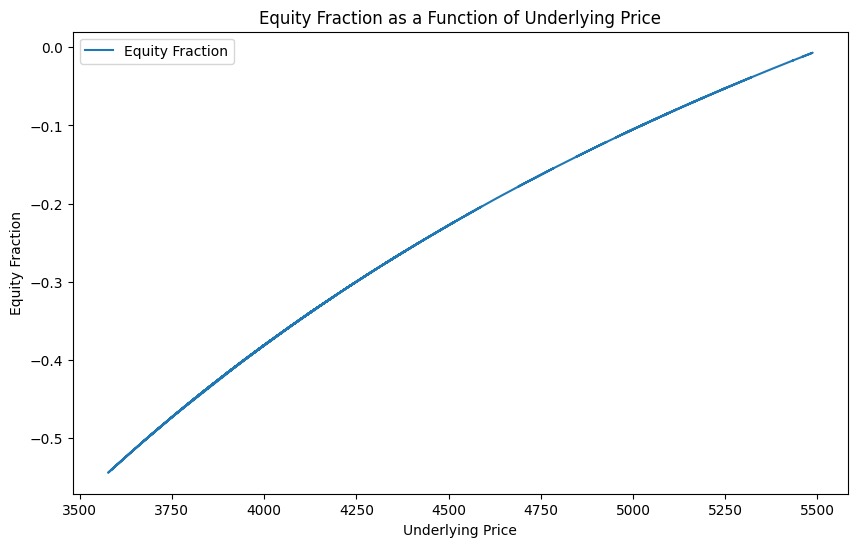

In [4]:
# Replicating portfolio for each day in the observation window
# number of shares to buy/sell
data['replicating_portfolio'] = (data['Close'] - K) / data['Close']

# Equity fraction as a function of the underlying price at a specific point in time
specific_time = '2024-06-03'
equity_fraction = data[data['Date'] == specific_time]['replicating_portfolio'].values[0]
#dates OKK

print(f"Equity fraction on {specific_time}: {equity_fraction:.4f}")

# Plotting the equity fraction as a function of the underlying price
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data['Close'], data['replicating_portfolio'], label='Equity Fraction')
plt.xlabel('Underlying Price')
plt.ylabel('Equity Fraction')
plt.title('Equity Fraction as a Function of Underlying Price')
plt.legend()
plt.show()